In [2]:
import pandas as pd
import numpy as np

data_df = pd.read_csv('../imputing/imputed_mutation_matrix.csv')
data_df = data_df.drop(columns=['Unnamed: 0'])
data_df

,ABL1,ABRAXAS1,ACVR1,AGO2,AKT1,AKT2,AKT3,ALB,ALK,ALOX12B,...,WWTR1,XIAP,XPO1,XRCC2,YAP1,YES1,ZFHX3,ZNRF3,ZRSR2,MSI
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
label_df = pd.read_csv('../data/mutation_matrix_cleaned.csv')
# only keep the last column which is the label
label_df = label_df.iloc[:, -1]
label_df

0        0
1        0
2        1
3        1
4        0
        ..
16904    1
16905    1
16906    0
16907    0
16908    0
Name: Stage, Length: 16909, dtype: int64

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Convert DataFrame to PyTorch tensor
X = torch.tensor(data_df.values, dtype=torch.float32)  # Mutation data
y = torch.tensor(label_df.values, dtype=torch.long)  # Labels

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to PyTorch Dataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [5]:
class CancerTransformer(nn.Module):
    def __init__(self, num_genes=data_df.shape[1], embed_dim=128, num_heads=8, ff_dim=256, num_layers=4, dropout=0.2):
        super(CancerTransformer, self).__init__()

        # Embedding layer for binary mutation (0,1) → Continuous space
        self.embedding = nn.Linear(num_genes, embed_dim)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.fc = nn.Sequential(
            nn.Linear(embed_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1),
            nn.Sigmoid()  # For binary classification
        )

    def forward(self, x):
        x = self.embedding(x)  # Map binary input to embedding space
        x = x.unsqueeze(1)  # Add sequence dimension for Transformer (N, Seq, D)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Pooling
        x = self.fc(x)  # Classification
        return x
    
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Model
model = CancerTransformer().to(device)

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy for prognosis classification
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)


/home/lyce/miniconda3/envs/dlg/lib/python3.11/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/100, Loss: 0.6808
Epoch 2/100, Loss: 0.6669
Epoch 3/100, Loss: 0.6559
Epoch 4/100, Loss: 0.6464
Epoch 5/100, Loss: 0.6362
Epoch 6/100, Loss: 0.6247
Epoch 7/100, Loss: 0.6094
Epoch 8/100, Loss: 0.5911
Epoch 9/100, Loss: 0.5647
Epoch 10/100, Loss: 0.5368
Epoch 11/100, Loss: 0.4995
Epoch 12/100, Loss: 0.4679
Epoch 13/100, Loss: 0.4395
Epoch 14/100, Loss: 0.4163
Epoch 15/100, Loss: 0.3948
Epoch 16/100, Loss: 0.3732
Epoch 17/100, Loss: 0.3629
Epoch 18/100, Loss: 0.3340
Epoch 19/100, Loss: 0.3245
Epoch 20/100, Loss: 0.3086
Epoch 21/100, Loss: 0.3012
Epoch 22/100, Loss: 0.2937
Epoch 23/100, Loss: 0.2820
Epoch 24/100, Loss: 0.2731
Epoch 25/100, Loss: 0.2635
Epoch 26/100, Loss: 0.2580
Epoch 27/100, Loss: 0.2539
Epoch 28/100, Loss: 0.2432
Epoch 29/100, Loss: 0.2391
Epoch 30/100, Loss: 0.2378
Epoch 31/100, Loss: 0.2296
Epoch 32/100, Loss: 0.2194
Epoch 33/100, Loss: 0.2221
Epoch 34/100, Loss: 0.2189
Epoch 35/100, Loss: 0.2136
Epoch 36/100, Loss: 0.2063
Epoch 37/100, Loss: 0.1999
Epoch 38/1

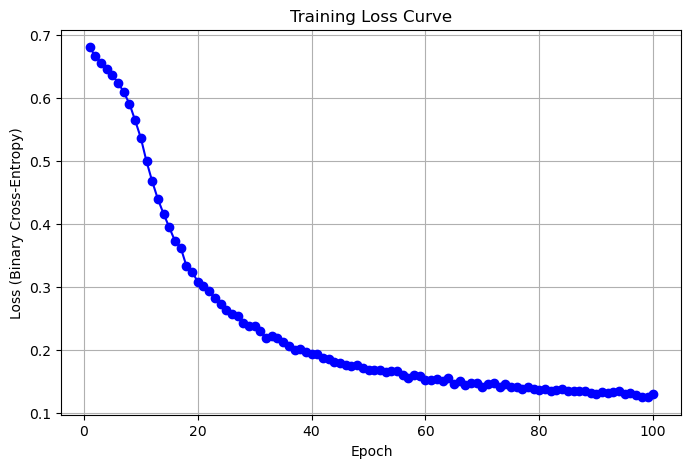

In [6]:

# Training Loop
import matplotlib.pyplot as plt

num_epochs = 100

train_losses = []  # Store loss per epoch

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        X_batch, y_batch = batch
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

print("Training complete.")

# Loss Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel("Epoch")
plt.ylabel("Loss (Binary Cross-Entropy)")
plt.title("Training Loss Curve")
plt.grid()

# Save the plot
plt.savefig("../fig/training_loss_curve.png")
plt.show()

# save the model
torch.save(model.state_dict(), '../models/cancer_transformer_model.pth')

Test Accuracy: 0.5506
AUC-ROC: 0.5427


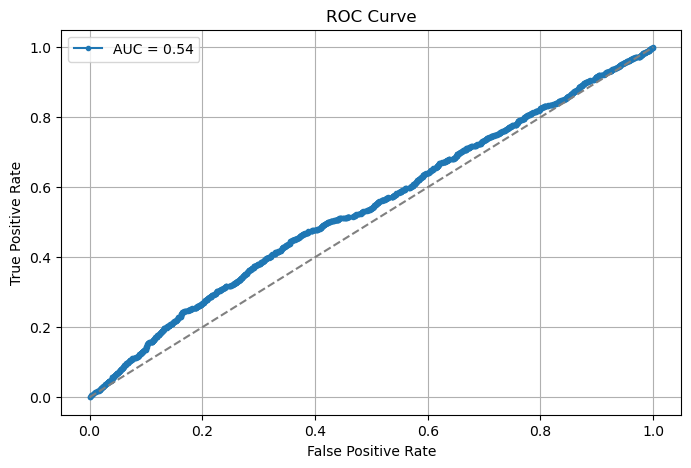

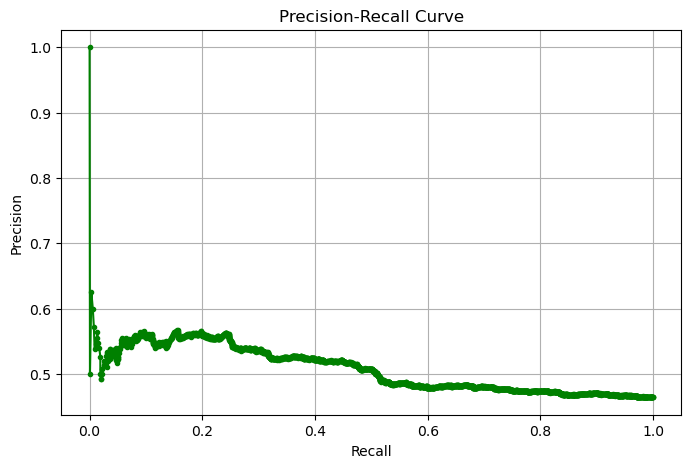

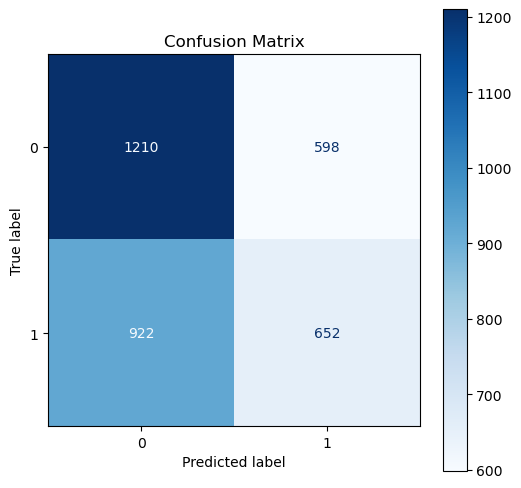

In [7]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

# Model Evaluation
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for batch in test_loader:
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        
        outputs = model(X_batch).cpu().numpy()
        y_pred.extend(outputs)
        y_true.extend(y_batch.numpy())

# Convert predictions to binary labels
y_pred_binary = (np.array(y_pred).flatten() > 0.5).astype(int)
y_true = np.array(y_true).flatten()

# Compute metrics
accuracy = accuracy_score(y_true, y_pred_binary)
auc_score = roc_auc_score(y_true, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"AUC-ROC: {auc_score:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, marker='.', label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
# Save the plot
plt.savefig("../fig/roc_curve.png")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.', color='g')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
# Save the plot
plt.savefig("../fig/precision_recall_curve.png")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues")
plt.title("Confusion Matrix")
# Save the plot
plt.savefig("../fig/confusion_matrix.png")
plt.show()